In [1]:
import pandas as pd
import glob
import protfasta

## Gathering variants
Gathering information on other variant types:
- AlphaMissense 10 most + least pathogenic variants per AD
- All gnomAD variants in AD
- Here: **All Clinvar variants in AD try 2**
  
Try 1: http://localhost:8888/notebooks/Desktop%2FStaller_Lab%2FSFARI%2Fnotebooks%2FOther%20variants%20for%20Caitlin%20experiment%20-%20ClinVar%20attempt%201.ipynb
just downloaded table from clinvar, but multiple protein changes are listed per variant. could be data for each transcript

Going to take a different approach here

Plan:

0. Obtain ENST codes used for the 15 ADs
1. Use biomart to find the RefSeq mRNA ID  corresponding to each ENST
2. Manually: search for each RefSeq mRNA ID in Variation Viewer, download all variants
    - Choose:
        - "In Clinvar"
        - "Single nucleotide variant"
        - "Missense Variant"
3. Combine all variant file into one that resembles other variant files
4. Run soto analysis steps to filter and annotate
5. Check for consistency
6. Variants to fasta script
7. Add to summary table

---
#### 0. Obtain ENST codes used for the 15 ADs

In [2]:
clinvar_gene_filepaths= glob.glob('../output/caitlin_experiment/variant fastas/*')
clinvar_gene_filepaths

['../output/caitlin_experiment/variant fastas/ERG_P11308_AD_118-261_seq_adj',
 '../output/caitlin_experiment/variant fastas/NCOA1_Q15788_AD_840-1011',
 '../output/caitlin_experiment/variant fastas/CAMTA2_O94983_AD_472-581',
 '../output/caitlin_experiment/variant fastas/OTX1_P32242_AD_172-354',
 '../output/caitlin_experiment/variant fastas/NCOA1_Q15788_AD_1241-1385',
 '../output/caitlin_experiment/variant fastas/CAMTA2_O94983_AD_285-468',
 '../output/caitlin_experiment/variant fastas/IKZF1_Q13422_AD_284-365',
 '../output/caitlin_experiment/variant fastas/NKX2-2_O95096_AD_220-273',
 '../output/caitlin_experiment/variant fastas/PAX6_P26367_AD_271-422',
 '../output/caitlin_experiment/variant fastas/NR4A2_P43354_AD_584-598',
 '../output/caitlin_experiment/variant fastas/MEIS2_O14770_AD_340-477',
 '../output/caitlin_experiment/variant fastas/PITX1_P78337_AD_234-283',
 '../output/caitlin_experiment/variant fastas/ERG_P11308_AD_433-479_seq_adj',
 '../output/caitlin_experiment/variant fastas/NR

In [3]:
genes = pd.DataFrame({"filepath" : clinvar_gene_filepaths})
genes["Gene"] = genes["filepath"].str.split("/").str[-1].str.split("_").str[0]
genes

,filepath,Gene
0,../output/caitlin_experiment/variant fastas/ER...,ERG
1,../output/caitlin_experiment/variant fastas/NC...,NCOA1
2,../output/caitlin_experiment/variant fastas/CA...,CAMTA2
3,../output/caitlin_experiment/variant fastas/OT...,OTX1
4,../output/caitlin_experiment/variant fastas/NC...,NCOA1
5,../output/caitlin_experiment/variant fastas/CA...,CAMTA2
6,../output/caitlin_experiment/variant fastas/IK...,IKZF1
7,../output/caitlin_experiment/variant fastas/NK...,NKX2-2
8,../output/caitlin_experiment/variant fastas/PA...,PAX6
9,../output/caitlin_experiment/variant fastas/NR...,NR4A2


In [4]:
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
enst_codes = pd.read_csv("../data/SFARI_TFs_with_ENST_corrected.csv", index_col = 0)

# Adding uniprotID and ENST used
genes = pd.merge(known_ADs[["Gene", "uniprotID"]], genes, on = "Gene")
genes = pd.merge(enst_codes, genes, on = "uniprotID")
genes["ENST"] = genes["ENST"].str.split(".").str[0]

genes

,uniprotID,ENST,Gene,filepath
0,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...
1,P32242,ENST00000282549,OTX1,../output/caitlin_experiment/variant fastas/OT...
2,P78337,ENST00000265340,PITX1,../output/caitlin_experiment/variant fastas/PI...
3,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...
4,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...
5,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...
6,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...
7,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...
8,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...
9,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...


In [5]:
# Making sure these are the right ENST codes
for ENST in genes["ENST"]:
    pd.read_csv("../soto_analysis/outputs/mutations/cds_bed_format/" + ENST)

# Did not error, so correct.

---
#### 1. Use biomart to find the RefSeq mRNA ID corresponding to each ENST

In [6]:
# List of gene names

for gene in set(genes["Gene"]):
    print(gene)

PAX5
CAMTA2
NKX2-2
MEIS2
NCOA1
PAX6
PITX1
ERG
NR4A2
IKZF1
OTX1


Biomart options:
- Ensembl genes 112
- Human genes (GRCh38.p14)
- Filters > Gene Name(s), input those above
- Attributes: added RefSeq mRNA ID

Downloaded unique results only

In [7]:
enst_refseq = pd.read_csv("../data/ENST_to_RefSeq_for15.txt", sep = "\t")
enst_refseq = enst_refseq.rename(columns = {"Transcript stable ID" : "ENST"})
enst_refseq

,Gene stable ID,Gene stable ID version,ENST,Transcript stable ID version,RefSeq mRNA ID
0,ENSG00000125820,ENSG00000125820.6,ENST00000377142,ENST00000377142.5,NM_001424412
1,ENSG00000125820,ENSG00000125820.6,ENST00000377142,ENST00000377142.5,NM_002509
2,ENSG00000196092,ENSG00000196092.14,ENST00000358127,ENST00000358127.9,NM_016734
3,ENSG00000196092,ENSG00000196092.14,ENST00000377852,ENST00000377852.7,NM_001280547
4,ENSG00000196092,ENSG00000196092.14,ENST00000523241,ENST00000523241.6,NM_001280549
...,...,...,...,...,...
271,ENSG00000153234,ENSG00000153234.16,ENST00000409108,ENST00000409108.6,NaN
272,ENSG00000153234,ENSG00000153234.16,ENST00000429376,ENST00000429376.5,NaN
273,ENSG00000153234,ENSG00000153234.16,ENST00000406048,ENST00000406048.2,NaN
274,ENSG00000153234,ENSG00000153234.16,ENST00000424077,ENST00000424077.1,NaN


In [8]:
enst_refseq[enst_refseq["ENST"] == "ENST00000377142"]
# There will be duplicate downloads later because has 2 diff ref seqs corresp to same gene


,Gene stable ID,Gene stable ID version,ENST,Transcript stable ID version,RefSeq mRNA ID
0,ENSG00000125820,ENSG00000125820.6,ENST00000377142,ENST00000377142.5,NM_001424412
1,ENSG00000125820,ENSG00000125820.6,ENST00000377142,ENST00000377142.5,NM_002509


In [9]:
# Use to add RefSeq column to genes table
genes = pd.merge(genes, enst_refseq[["ENST", "RefSeq mRNA ID"]], on = "ENST")
genes

,uniprotID,ENST,Gene,filepath,RefSeq mRNA ID
0,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...,NM_001424412
1,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...,NM_002509
2,P32242,ENST00000282549,OTX1,../output/caitlin_experiment/variant fastas/OT...,NM_014562
3,P78337,ENST00000265340,PITX1,../output/caitlin_experiment/variant fastas/PI...,NM_002653
4,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099
5,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099
6,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099
7,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099
8,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...,NM_182918
9,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...,NM_182918


---
#### Manually: search for each RefSeq mRNA ID in Variation Viewer, download all variants
- Choose:
    - "In Clinvar: Yes"
    - "Variant type: Single nucleotide variant"
    - "Molecular consequence: Missense Variant"
    - Add "alleles" under Download
    - Choose the right transcript

In [10]:
for rf_id in set(genes["RefSeq mRNA ID"]):
    print(rf_id)

NM_015099
NM_014562
NM_002653
NM_001424412
NM_006060
NM_003743
NM_001127612
NM_006186
NM_002509
NM_182918
NM_016734
NM_170675


In [11]:
# Check that I downloaded everything
for rf_id in set(genes["RefSeq mRNA ID"]):
    pd.read_csv("../data/clinvar_by_transcript/" + rf_id, header = 5, sep = "\t")

# didnt error, so i did!

---
#### 3. Combine all variant file into one that resembles other variant files


In [12]:
#What does format of other variant files look like?
# Looking at gnomad

pd.read_csv("../soto_analysis/raw_files/gnomad.bed", sep = "\t", nrows = 10, header = None)

,0,1,2,3,4,5
0,2,207081140,207081141,T,C,3.216086e-06
1,2,207081144,207081145,G,C,7.777610e-07
2,2,207081145,207081146,C,G,7.714145e-07
3,2,207081146,207081147,C,T,1.529487e-06
4,2,207081147,207081148,C,T,5.777024e-06
5,2,207081148,207081149,C,T,4.775595e-06
6,2,207081149,207081150,C,A,7.497039e-07
7,2,207081149,207081150,C,T,7.497050e-07
8,2,207081150,207081151,T,C,2.795584e-06
9,2,207081152,207081153,C,T,3.701565e-06


Need to write tsv with:
- chromosome number (extract it from another file)
- start and "end"
- ref nt
- alt nt
- allele freq, can be placeholder for now

In [13]:
# Extracting chromosome number
chroms = []
for ENST in genes["ENST"]:
    df = pd.read_csv("../soto_analysis/outputs/mutations/cds_bed_format/" + ENST, sep = "\t", header = None)
    chroms.append(df[0].iloc[0])
genes["chr"] = chroms
genes

,uniprotID,ENST,Gene,filepath,RefSeq mRNA ID,chr
0,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...,NM_001424412,20
1,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...,NM_002509,20
2,P32242,ENST00000282549,OTX1,../output/caitlin_experiment/variant fastas/OT...,NM_014562,2
3,P78337,ENST00000265340,PITX1,../output/caitlin_experiment/variant fastas/PI...,NM_002653,5
4,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
5,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
6,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
7,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
8,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...,NM_182918,21
9,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...,NM_182918,21


In [14]:
rf_chr_dict = dict(zip(genes["RefSeq mRNA ID"], genes["chr"]))
rf_chr_dict

{'NM_001424412': 20,
 'NM_002509': 20,
 'NM_014562': 2,
 'NM_002653': 5,
 'NM_015099': 17,
 'NM_182918': 21,
 'NM_006060': 7,
 'NM_170675': 15,
 'NM_003743': 2,
 'NM_006186': 2,
 'NM_016734': 9,
 'NM_001127612': 11}

In [15]:
all_variants = []

for rf_id in set(genes["RefSeq mRNA ID"]):
    chrom = rf_chr_dict[rf_id]
    gene_df = pd.read_csv("../data/clinvar_by_transcript/" + rf_id, sep = "\t", header = 5)
    gene_df["chr"] = chrom
    gene_df["RefSeq mRNA ID"] = rf_id
    all_variants.append(gene_df)

all_variants = pd.concat(all_variants)
all_variants

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID
0,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"C,A,G,T",C=0.269988,NaN,NaN,26886562,17,NM_015099
0,rs61742369,63055927,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"G,A,C,T",A=0.00874453,NaN,NaN,NaN,2,NM_014562
0,rs479632,135028828,single nucleotide variant,PITX1 and 2 more,",missense variant",benign,"C,A,G",G=0.306215,NaN,G=0.300144,"18053270,20054692",5,NM_002653
1,rs141612135,135028931,single nucleotide variant,PITX1 and 3 more,",missense variant",likely-pathogenic,"C,A,G,T",NaN,NaN,NaN,NaN,5,NM_002653
2,rs746291345,135029030,single nucleotide variant,PITX1 and 1 more,",missense variant",uncertain-significance,"C,T",NaN,NaN,T=1.65098e-05,NaN,5,NM_002653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,rs2140100040,37098079,single nucleotide variant,MEIS2 and 3 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"G,C",NaN,NaN,NaN,NaN,15,NM_170675
21,rs144628203,37098092,single nucleotide variant,MEIS2 and 5 more,",missense variant,nc transcript variant,5 prim...",likely-benign,"G,A,T",A=0.000156152,NaN,NaN,NaN,15,NM_170675
22,rs774160502,37098115,single nucleotide variant,MEIS2 and 5 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"T,C,G",NaN,NaN,C=2.54734e-05,NaN,15,NM_170675
23,rs1555473800,37098174,single nucleotide variant,MEIS2 and 3 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"C,T",NaN,NaN,NaN,NaN,15,NM_170675


In [16]:
all_variants["Alleles"] = all_variants["Alleles"].str.split(",")
all_variants

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID
0,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"[C, A, G, T]",C=0.269988,NaN,NaN,26886562,17,NM_015099
0,rs61742369,63055927,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562
0,rs479632,135028828,single nucleotide variant,PITX1 and 2 more,",missense variant",benign,"[C, A, G]",G=0.306215,NaN,G=0.300144,"18053270,20054692",5,NM_002653
1,rs141612135,135028931,single nucleotide variant,PITX1 and 3 more,",missense variant",likely-pathogenic,"[C, A, G, T]",NaN,NaN,NaN,NaN,5,NM_002653
2,rs746291345,135029030,single nucleotide variant,PITX1 and 1 more,",missense variant",uncertain-significance,"[C, T]",NaN,NaN,T=1.65098e-05,NaN,5,NM_002653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,rs2140100040,37098079,single nucleotide variant,MEIS2 and 3 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[G, C]",NaN,NaN,NaN,NaN,15,NM_170675
21,rs144628203,37098092,single nucleotide variant,MEIS2 and 5 more,",missense variant,nc transcript variant,5 prim...",likely-benign,"[G, A, T]",A=0.000156152,NaN,NaN,NaN,15,NM_170675
22,rs774160502,37098115,single nucleotide variant,MEIS2 and 5 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[T, C, G]",NaN,NaN,C=2.54734e-05,NaN,15,NM_170675
23,rs1555473800,37098174,single nucleotide variant,MEIS2 and 3 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[C, T]",NaN,NaN,NaN,NaN,15,NM_170675


In [17]:
all_variants["REF"] = [_[0] for _ in all_variants["Alleles"]]
all_variants["ALT"] = [_[1:] for _ in all_variants["Alleles"]]
all_variants

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,REF,ALT
0,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"[C, A, G, T]",C=0.269988,NaN,NaN,26886562,17,NM_015099,C,"[A, G, T]"
0,rs61742369,63055927,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562,G,"[A, C, T]"
0,rs479632,135028828,single nucleotide variant,PITX1 and 2 more,",missense variant",benign,"[C, A, G]",G=0.306215,NaN,G=0.300144,"18053270,20054692",5,NM_002653,C,"[A, G]"
1,rs141612135,135028931,single nucleotide variant,PITX1 and 3 more,",missense variant",likely-pathogenic,"[C, A, G, T]",NaN,NaN,NaN,NaN,5,NM_002653,C,"[A, G, T]"
2,rs746291345,135029030,single nucleotide variant,PITX1 and 1 more,",missense variant",uncertain-significance,"[C, T]",NaN,NaN,T=1.65098e-05,NaN,5,NM_002653,C,[T]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,rs2140100040,37098079,single nucleotide variant,MEIS2 and 3 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[G, C]",NaN,NaN,NaN,NaN,15,NM_170675,G,[C]
21,rs144628203,37098092,single nucleotide variant,MEIS2 and 5 more,",missense variant,nc transcript variant,5 prim...",likely-benign,"[G, A, T]",A=0.000156152,NaN,NaN,NaN,15,NM_170675,G,"[A, T]"
22,rs774160502,37098115,single nucleotide variant,MEIS2 and 5 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[T, C, G]",NaN,NaN,C=2.54734e-05,NaN,15,NM_170675,T,"[C, G]"
23,rs1555473800,37098174,single nucleotide variant,MEIS2 and 3 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[C, T]",NaN,NaN,NaN,NaN,15,NM_170675,C,[T]


In [18]:
all_variants_expanded = all_variants.explode("ALT")
all_variants_expanded = all_variants_expanded.reset_index(drop = True)
all_variants_expanded

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,REF,ALT
0,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"[C, A, G, T]",C=0.269988,NaN,NaN,26886562,17,NM_015099,C,A
1,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"[C, A, G, T]",C=0.269988,NaN,NaN,26886562,17,NM_015099,C,G
2,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"[C, A, G, T]",C=0.269988,NaN,NaN,26886562,17,NM_015099,C,T
3,rs61742369,63055927,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562,G,A
4,rs61742369,63055927,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562,G,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,rs774160502,37098115,single nucleotide variant,MEIS2 and 5 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[T, C, G]",NaN,NaN,C=2.54734e-05,NaN,15,NM_170675,T,G
475,rs1555473800,37098174,single nucleotide variant,MEIS2 and 3 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[C, T]",NaN,NaN,NaN,NaN,15,NM_170675,C,T
476,rs757192671,37098195,single nucleotide variant,MEIS2 and 7 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[T, A, C, G]",NaN,NaN,C=2.26183e-05,NaN,15,NM_170675,T,A
477,rs757192671,37098195,single nucleotide variant,MEIS2 and 7 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[T, A, C, G]",NaN,NaN,C=2.26183e-05,NaN,15,NM_170675,T,C


In [19]:
all_variants_expanded["start"] = all_variants_expanded["Location"] - 1
all_variants_expanded["end"] = all_variants_expanded["Location"]
all_variants_expanded

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,REF,ALT,start,end
0,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"[C, A, G, T]",C=0.269988,NaN,NaN,26886562,17,NM_015099,C,A,4980522,4980523
1,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"[C, A, G, T]",C=0.269988,NaN,NaN,26886562,17,NM_015099,C,G,4980522,4980523
2,rs238234,4980523,single nucleotide variant,CAMTA2 and 3 more,",missense variant",benign,"[C, A, G, T]",C=0.269988,NaN,NaN,26886562,17,NM_015099,C,T,4980522,4980523
3,rs61742369,63055927,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562,G,A,63055926,63055927
4,rs61742369,63055927,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562,G,C,63055926,63055927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,rs774160502,37098115,single nucleotide variant,MEIS2 and 5 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[T, C, G]",NaN,NaN,C=2.54734e-05,NaN,15,NM_170675,T,G,37098114,37098115
475,rs1555473800,37098174,single nucleotide variant,MEIS2 and 3 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[C, T]",NaN,NaN,NaN,NaN,15,NM_170675,C,T,37098173,37098174
476,rs757192671,37098195,single nucleotide variant,MEIS2 and 7 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[T, A, C, G]",NaN,NaN,C=2.26183e-05,NaN,15,NM_170675,T,A,37098194,37098195
477,rs757192671,37098195,single nucleotide variant,MEIS2 and 7 more,",missense variant,nc transcript variant,5 prim...",uncertain-significance,"[T, A, C, G]",NaN,NaN,C=2.26183e-05,NaN,15,NM_170675,T,C,37098194,37098195


In [20]:
all_vars_exp_bed = all_variants_expanded[["chr", "start", "end", "REF", "ALT"]]
all_vars_exp_bed["af"] = "."
all_vars_exp_bed

/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_37331/367763691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_vars_exp_bed["af"] = "."


,chr,start,end,REF,ALT,af
0,17,4980522,4980523,C,A,.
1,17,4980522,4980523,C,G,.
2,17,4980522,4980523,C,T,.
3,2,63055926,63055927,G,A,.
4,2,63055926,63055927,G,C,.
...,...,...,...,...,...,...
474,15,37098114,37098115,T,G,.
475,15,37098173,37098174,C,T,.
476,15,37098194,37098195,T,A,.
477,15,37098194,37098195,T,C,.


In [21]:
# checking for duplicates
print(len(all_vars_exp_bed))
print(len(all_vars_exp_bed.drop_duplicates()))
# likely due to NKX2-2 having 2 diff refseq ids

all_vars_exp_bed = all_vars_exp_bed.drop_duplicates()
#all_vars_exp_bed.to_csv("../soto_analysis/raw_files/clinvar_for_15.bed", index=False, sep='\t', header=None)

479
465


---
#### 4. Run soto analysis steps to filter and annotate

python3 ../scripts/get_full_mutations.py --variants_filename clinvar_for_15.bed --variants_folder /Users/sanjanakotha/Desktop/Staller_Lab/SFARI/soto_analysis/raw_files/ --sort_TFs true --sort_variants true

python3 ../scripts/classify_mutations.py --variants_filename clinvar_for_15.bed

python3 ../scripts/get_mutations_domains_snv_classified.py --domain none --variants_filename clinvar_for_15.bed

---
#### 5. Check for consistency
Manually checked a few, they are consistent

In [22]:
pax6_vars = all_variants_expanded[all_variants_expanded["Gene"].str.contains("PAX6")]
pax6_vars.head()

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,REF,ALT,start,end
133,rs934715799,31789662,single nucleotide variant,PAX6 and 3 more,",missense variant,nc transcript variant,3 prim...",uncertain-significance,"[A, C]",NaN,NaN,NaN,NaN,11,NM_001127612,A,C,31789661,31789662
134,rs1468270124,31789687,single nucleotide variant,PAX6 and 3 more,",missense variant,nc transcript variant,3 prim...",uncertain-significance,"[A, T]",NaN,NaN,NaN,NaN,11,NM_001127612,A,T,31789686,31789687
135,rs886048199,31789727,single nucleotide variant,PAX6 and 3 more,",missense variant,nc transcript variant,3 prim...",uncertain-significance,"[C, T]",NaN,NaN,NaN,NaN,11,NM_001127612,C,T,31789726,31789727
136,rs886048201,31789827,single nucleotide variant,PAX6 and 5 more,",missense variant,nc transcript variant,3 prim...",uncertain-significance,"[C, G, T]",NaN,NaN,NaN,NaN,11,NM_001127612,C,G,31789826,31789827
137,rs886048201,31789827,single nucleotide variant,PAX6 and 5 more,",missense variant,nc transcript variant,3 prim...",uncertain-significance,"[C, G, T]",NaN,NaN,NaN,NaN,11,NM_001127612,C,T,31789826,31789827


In [23]:
pax6_vars[pax6_vars["Location"] == 31789935]

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,REF,ALT,start,end
139,rs121907922,31789935,single nucleotide variant,PAX6 and 5 more,"stop lost,,missense variant,nonsense (stop gai...",pathogenic,"[T, A, C]",NaN,NaN,NaN,"11431688,12552561,12731001,16098226,28321846",11,NM_001127612,T,A,31789934,31789935
140,rs121907922,31789935,single nucleotide variant,PAX6 and 5 more,"stop lost,,missense variant,nonsense (stop gai...",pathogenic,"[T, A, C]",NaN,NaN,NaN,"11431688,12552561,12731001,16098226,28321846",11,NM_001127612,T,C,31789934,31789935


In [24]:
genes

,uniprotID,ENST,Gene,filepath,RefSeq mRNA ID,chr
0,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...,NM_001424412,20
1,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...,NM_002509,20
2,P32242,ENST00000282549,OTX1,../output/caitlin_experiment/variant fastas/OT...,NM_014562,2
3,P78337,ENST00000265340,PITX1,../output/caitlin_experiment/variant fastas/PI...,NM_002653,5
4,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
5,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
6,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
7,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
8,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...,NM_182918,21
9,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...,NM_182918,21


---
5. Getting disease data

In [25]:
# Read in annotated overlapping variants, 

AD_fasta_paths = glob.glob("../soto_analysis/outputs/AD_clinvar_for_15_variant_fasta/*")

all_fastas = []

for fasta in AD_fasta_paths:
    fasta_dict = protfasta.read_fasta(fasta)
    df = pd.DataFrame({"id" : fasta_dict.keys(), "seq": fasta_dict.values()})
    df["AD"] = fasta
    all_fastas.append(df)

all_fastas = pd.concat(all_fastas)
all_fastas["AD"] = all_fastas["AD"].str.split("/").str[-1]
all_fastas

,id,seq,AD
0,g.21.38423435G>C(p.Asn121Lys),MTTKERRVIVPADPTLWSTDHVRQWLEWAVKEYGLPDVNILLFQNI...,ERG_P11308_AD_118-261
0,g.2.63055927G>A(p.Gly226Ser),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354
1,g.2.63055927G>C(p.Gly226Arg),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354
2,g.2.63055927G>T(p.Gly226Cys),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354
0,g.7.50399956G>A(p.Ala297Thr),GDKGLSDTPYDSSTSYEKENEMMKSHVMDQAINNAINYLGAESLRP...,IKZF1_Q13422_AD_284-365
...,...,...,...
8,g.9.36882055G>C(p.Pro321Ala),GRDLASTTLPGYPPHVPAAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358
9,g.9.36882055G>T(p.Pro321Thr),GRDLASTTLPGYPPHVPTAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358
10,g.9.36882062G>T(p.His318Gln),GRDLASTTLPGYPPQVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358
11,g.9.36882093G>A(p.Ala308Val),GRDLVSTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358


In [26]:
all_fastas["Location"] = all_fastas["id"].str.split(".").str[2].str.split(">").str[0].str[:-1].astype(int)
all_fastas["REF"] = all_fastas["id"].str.split(">").str[0].str[-1]
all_fastas["ALT"] = all_fastas["id"].str.split(">").str[1].str[0]
all_fastas

,id,seq,AD,Location,REF,ALT
0,g.21.38423435G>C(p.Asn121Lys),MTTKERRVIVPADPTLWSTDHVRQWLEWAVKEYGLPDVNILLFQNI...,ERG_P11308_AD_118-261,38423435,G,C
0,g.2.63055927G>A(p.Gly226Ser),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354,63055927,G,A
1,g.2.63055927G>C(p.Gly226Arg),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354,63055927,G,C
2,g.2.63055927G>T(p.Gly226Cys),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354,63055927,G,T
0,g.7.50399956G>A(p.Ala297Thr),GDKGLSDTPYDSSTSYEKENEMMKSHVMDQAINNAINYLGAESLRP...,IKZF1_Q13422_AD_284-365,50399956,G,A
...,...,...,...,...,...,...
8,g.9.36882055G>C(p.Pro321Ala),GRDLASTTLPGYPPHVPAAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882055,G,C
9,g.9.36882055G>T(p.Pro321Thr),GRDLASTTLPGYPPHVPTAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882055,G,T
10,g.9.36882062G>T(p.His318Gln),GRDLASTTLPGYPPQVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882062,G,T
11,g.9.36882093G>A(p.Ala308Val),GRDLVSTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882093,G,A


In [27]:
# Adding variant info to the variants in the fasta
all_fastas_merged = pd.merge(all_fastas, all_variants_expanded, how = "left", on = ["Location", "REF", "ALT"])
all_fastas_merged = all_fastas_merged.drop_duplicates("seq")
all_fastas_merged

,id,seq,AD,Location,REF,ALT,# Variant ID,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,start,end
0,g.21.38423435G>C(p.Asn121Lys),MTTKERRVIVPADPTLWSTDHVRQWLEWAVKEYGLPDVNILLFQNI...,ERG_P11308_AD_118-261,38423435,G,C,rs774580195,single nucleotide variant,ERG and 2 more,",missense variant,synonymous variant,",likely-benign,"[G, A, C]",NaN,NaN,A=8.28816e-06,NaN,21,NM_182918,38423434,38423435
1,g.2.63055927G>A(p.Gly226Ser),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354,63055927,G,A,rs61742369,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562,63055926,63055927
2,g.2.63055927G>C(p.Gly226Arg),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354,63055927,G,C,rs61742369,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562,63055926,63055927
3,g.2.63055927G>T(p.Gly226Cys),AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,OTX1_P32242_AD_172-354,63055927,G,T,rs61742369,single nucleotide variant,OTX1 and 3 more,",missense variant,nc transcript variant",benign,"[G, A, C, T]",A=0.00874453,NaN,NaN,NaN,2,NM_014562,63055926,63055927
4,g.7.50399956G>A(p.Ala297Thr),GDKGLSDTPYDSSTSYEKENEMMKSHVMDQAINNAINYLGAESLRP...,IKZF1_Q13422_AD_284-365,50399956,G,A,rs2153517575,single nucleotide variant,IKZF1 and 2 more,",missense variant,",uncertain-significance,"[G, A, T]",NaN,NaN,NaN,NaN,7,NM_006060,50399955,50399956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,g.9.36882055G>C(p.Pro321Ala),GRDLASTTLPGYPPHVPAAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882055,G,C,rs543302698,single nucleotide variant,PAX5 and 3 more,",missense variant,nc transcript variant,intron...",uncertain-significance,"[G, A, C, T]",A=0.000312305,NaN,NaN,NaN,9,NM_016734,36882054,36882055
67,g.9.36882055G>T(p.Pro321Thr),GRDLASTTLPGYPPHVPTAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882055,G,T,rs543302698,single nucleotide variant,PAX5 and 3 more,",missense variant,nc transcript variant,intron...",uncertain-significance,"[G, A, C, T]",A=0.000312305,NaN,NaN,NaN,9,NM_016734,36882054,36882055
68,g.9.36882062G>T(p.His318Gln),GRDLASTTLPGYPPQVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882062,G,T,rs144574685,single nucleotide variant,PAX5 and 2 more,",missense variant,nc transcript variant,intron...",likely-benign,"[G, A, T]",A=0.00140537,NaN,A=0.00026991,NaN,9,NM_016734,36882061,36882062
69,g.9.36882093G>A(p.Ala308Val),GRDLVSTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882093,G,A,rs35077960,single nucleotide variant,PAX5 and 2 more,",missense variant,nc transcript variant,intron...",benign,"[G, A, C]",A=0.0029669,NaN,A=0.00117001,25741868,9,NM_016734,36882092,36882093


In [28]:
cc_vars_counts = pd.DataFrame(all_fastas_merged["Most severe clinical significance"].value_counts())#.reset_index()
cc_vars_counts = cc_vars_counts.reset_index()
cc_vars_counts["temp"] = cc_vars_counts["Most severe clinical significance"]
cc_vars_counts["temp"] = cc_vars_counts["temp"].replace({"uncertain-significance" : 0, "benign" : 1, "likely-benign" : 2, "likely-pathogenic" : 3, "pathogenic" : 4})
cc_vars_counts = cc_vars_counts.sort_values(by = "temp")
cc_vars_counts

/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_37331/4134853865.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cc_vars_counts["temp"] = cc_vars_counts["temp"].replace({"uncertain-significance" : 0, "benign" : 1, "likely-benign" : 2, "likely-pathogenic" : 3, "pathogenic" : 4})


,Most severe clinical significance,count,temp
0,uncertain-significance,42,0
2,benign,6,1
3,likely-benign,5,2
4,likely-pathogenic,3,3
1,pathogenic,9,4


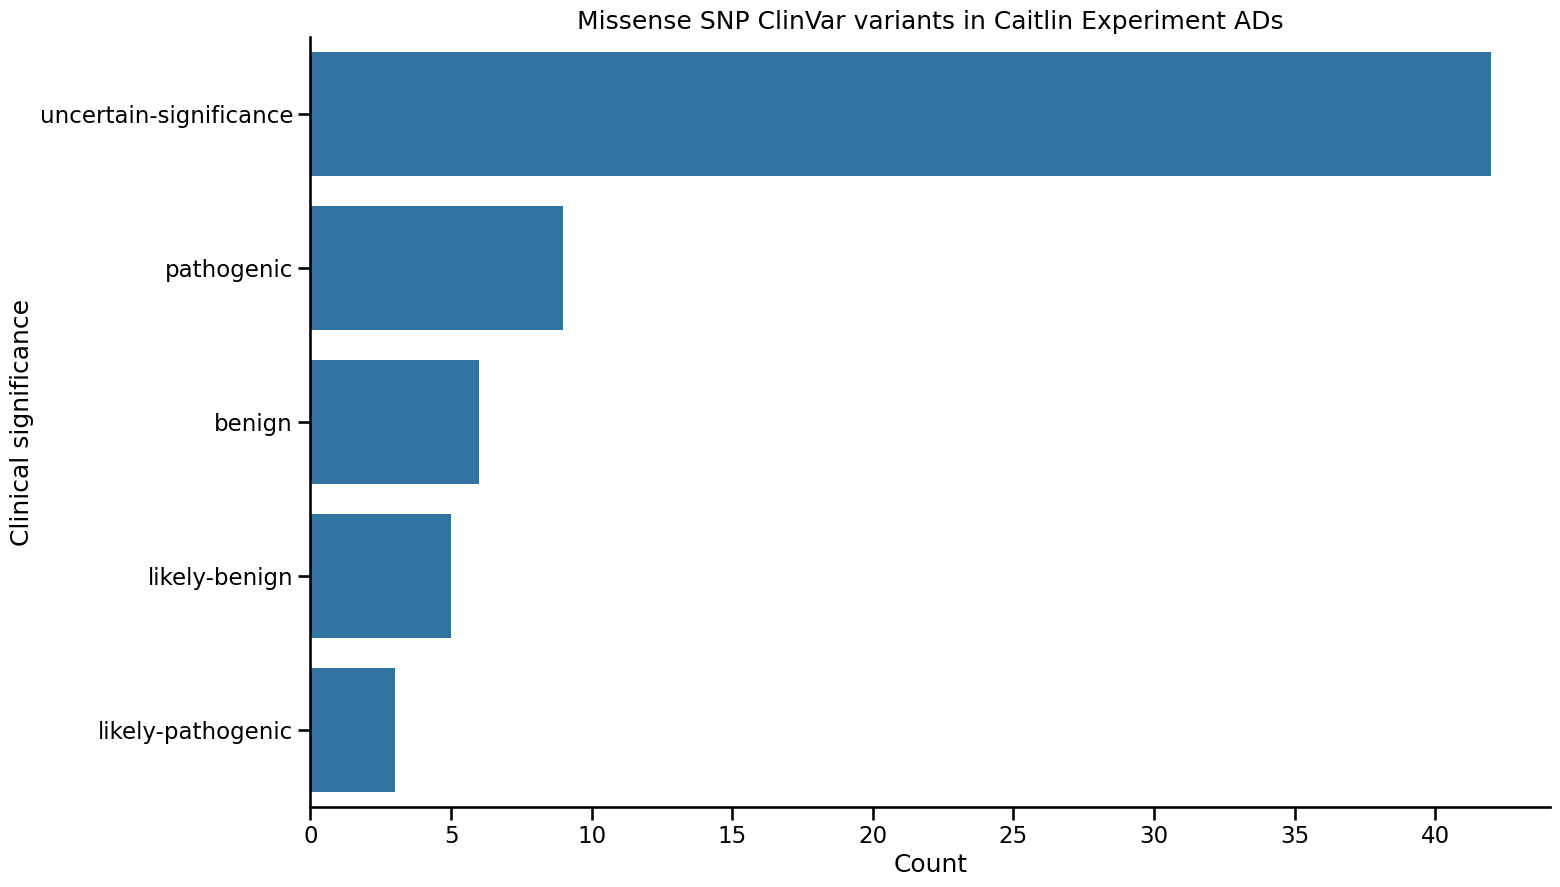

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
plt.title("Missense SNP ClinVar variants in Caitlin Experiment ADs")
plt.ylabel("Clinical significance")
plt.xlabel("Count")
sns.set_context('talk')
sns.barplot(cc_vars_counts.sort_values(by = "count", ascending = False), x="count", y="Most severe clinical significance", legend=False)
sns.despine();

In [30]:
# Focusing on pathogenic and likely pathogenic
path_AD_vars = all_fastas_merged[all_fastas_merged["Most severe clinical significance"].str.contains("pathogenic")]
path_AD_vars

,id,seq,AD,Location,REF,ALT,# Variant ID,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,start,end
22,g.11.31790710C>G(p.Gly395Arg),LRNQRRQASNTPSHIPISSSFSTSVYQPIPQPTTPVSSFTSGSMLG...,PAX6_P26367_AD_271-422,31790710,C,G,rs1131692318,single nucleotide variant,PAX6 and 7 more,",missense variant,nonsense (stop gained),nc tr...",pathogenic,"[C, A, G, T]",NaN,NaN,NaN,"7666404,28321846",11,NM_001127612,31790709,31790710
24,g.11.31790722T>C(p.Thr391Ala),LRNQRRQASNTPSHIPISSSFSTSVYQPIPQPTTPVSSFTSGSMLG...,PAX6_P26367_AD_271-422,31790722,T,C,rs121907926,single nucleotide variant,PAX6 and 3 more,",missense variant,nc transcript variant,intron...",pathogenic,"[T, C]",NaN,NaN,NaN,12721955,11,NM_001127612,31790721,31790722
31,g.11.31790805G>A(p.Ser363Leu),LRNQRRQASNTPSHIPISSSFSTSVYQPIPQPTTPVSSFTSGSMLG...,PAX6_P26367_AD_271-422,31790805,G,A,rs1411880763,single nucleotide variant,PAX6 and 5 more,",missense variant,nonsense (stop gained),nc tr...",pathogenic,"[G, A, T]",NaN,NaN,NaN,NaN,11,NM_001127612,31790804,31790805
34,g.11.31790845G>C(p.Gln350Glu),LRNQRRQASNTPSHIPISSSFSTSVYQPIPQPTTPVSSFTSGSMLG...,PAX6_P26367_AD_271-422,31790845,G,C,rs1237278944,single nucleotide variant,PAX6 and 2 more,",missense variant,nonsense (stop gained),nc tr...",pathogenic,"[G, A, C]",NaN,NaN,NaN,NaN,11,NM_001127612,31790844,31790845
42,g.11.31793521G>C(p.Arg317Gly),LRNQRRQASNTPSHIPISSSFSTSVYQPIPQPTTPVSSFTSGSMLG...,PAX6_P26367_AD_271-422,31793521,G,C,rs1057517785,single nucleotide variant,PAX6 and 2 more,",missense variant,nonsense (stop gained),nc tr...",pathogenic,"[G, A, C]",NaN,NaN,NaN,NaN,11,NM_001127612,31793520,31793521
47,g.11.31793739G>T(p.Gln277Lys),LRNQRRKASNTPSHIPISSSFSTSVYQPIPQPTTPVSSFTSGSMLG...,PAX6_P26367_AD_271-422,31793739,G,T,rs1592415563,single nucleotide variant,PAX6 and 2 more,",missense variant,nonsense (stop gained),nc tr...",pathogenic,"[G, A, T]",NaN,NaN,NaN,NaN,11,NM_001127612,31793738,31793739
53,g.5.135028931C>A(p.Gly265Cys),VPGMPNSGLNNINNLTGSSLNSAMSPGACPYCTPASPYSVYRDTCN...,PITX1_P78337_AD_234-283,135028931,C,A,rs141612135,single nucleotide variant,PITX1 and 3 more,",missense variant",likely-pathogenic,"[C, A, G, T]",NaN,NaN,NaN,NaN,5,NM_002653,135028930,135028931
54,g.5.135028931C>G(p.Gly265Arg),VPGMPNSGLNNINNLTGSSLNSAMSPGACPYRTPASPYSVYRDTCN...,PITX1_P78337_AD_234-283,135028931,C,G,rs141612135,single nucleotide variant,PITX1 and 3 more,",missense variant",likely-pathogenic,"[C, A, G, T]",NaN,NaN,NaN,NaN,5,NM_002653,135028930,135028931
55,g.5.135028931C>T(p.Gly265Ser),VPGMPNSGLNNINNLTGSSLNSAMSPGACPYSTPASPYSVYRDTCN...,PITX1_P78337_AD_234-283,135028931,C,T,rs141612135,single nucleotide variant,PITX1 and 3 more,",missense variant",likely-pathogenic,"[C, A, G, T]",NaN,NaN,NaN,NaN,5,NM_002653,135028930,135028931
62,g.9.36882054G>A(p.Pro321Leu),GRDLASTTLPGYPPHVPLAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,PAX5_Q02548_AD_304-358,36882054,G,A,rs577863510,single nucleotide variant,PAX5 and 3 more,",missense variant,nc transcript variant,intron...",pathogenic,"[G, A, C, T]",C=0.000312305,NaN,NaN,NaN,9,NM_016734,36882053,36882054


In [194]:
# Manually building df using dbSNP, searching for following variant IDs:
for rsid in set(path_AD_vars["# Variant ID"]):
    print(rsid)

rs1411880763
rs577863510
rs1057517785
rs121907926
rs141612135
rs1131692318
rs1237278944
rs1592415563


In [196]:
path_AD_vars.to_csv("../output/ClinVar_at_least_likely_path_caitlin_ADs.csv")

In [114]:
protfasta.read_fasta("../soto_analysis/outputs/AD_clinvar_for_15_variant_fasta/IKZF1_Q13422_AD_284-365")

{'g.7.50399956G>A(p.Ala297Thr)': 'GDKGLSDTPYDSSTSYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYQLHKPLAEGTPRSNHSA',
 'g.7.50399956G>T(p.Ala297Ser)': 'GDKGLSDTPYDSSSSYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYQLHKPLAEGTPRSNHSA',
 'g.7.50400068C>T(p.Pro334Leu)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTLPGGSEVVPVISPMYQLHKPLAEGTPRSNHSA',
 'g.7.50400101G>A(p.Ser345Asn)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVINPMYQLHKPLAEGTPRSNHSA',
 'g.7.50400114G>C(p.Gln349His)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYHLHKPLAEGTPRSNHSA',
 'g.7.50400143C>A(p.Pro359Gln)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYQLHKPLAEGTQRSNHSA',
 'g.7.50400143C>T(p.Pro359Leu)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYQLHKPLAEGTLRSNHSA'}

In [134]:
at_least_likely_path[at_least_likely_path["Location"] == 50400143]

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,REF,ALT,start,end


In [136]:
all_variants_expanded[all_variants_expanded["Location"] == 50399956]

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,REF,ALT,start,end
105,rs2153517575,50399956,single nucleotide variant,IKZF1 and 2 more,",missense variant,",uncertain-significance,"[G, A, T]",NaN,NaN,NaN,NaN,7,NM_006060,G,A,50399955,50399956
106,rs2153517575,50399956,single nucleotide variant,IKZF1 and 2 more,",missense variant,",uncertain-significance,"[G, A, T]",NaN,NaN,NaN,NaN,7,NM_006060,G,T,50399955,50399956


In [94]:
genes

,uniprotID,ENST,Gene,filepath,RefSeq mRNA ID,chr
0,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...,NM_001424412,20
1,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...,NM_002509,20
2,P32242,ENST00000282549,OTX1,../output/caitlin_experiment/variant fastas/OT...,NM_014562,2
3,P78337,ENST00000265340,PITX1,../output/caitlin_experiment/variant fastas/PI...,NM_002653,5
4,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
5,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
6,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
7,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...,NM_015099,17
8,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...,NM_182918,21
9,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...,NM_182918,21


In [96]:
pd.read_csv("../soto_analysis/outputs/mutations/domains_clinvar_for_15_snv_classified/ENST00000288319.bed", sep = "\t", header = None)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,21,38423434,38423435,AD,ENSG00000157554,.,-,ENST00000288319,21,38423434,...,-,21,38423434,38423435,G,A,.,N,N,Syn
1,21,38423434,38423435,AD,ENSG00000157554,.,-,ENST00000288319,21,38423434,...,-,21,38423434,38423435,G,C,.,N,K,No-Syn


{'g.7.50399956G>A(p.Ala297Thr)': 'GDKGLSDTPYDSSTSYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYQLHKPLAEGTPRSNHSA',
 'g.7.50399956G>T(p.Ala297Ser)': 'GDKGLSDTPYDSSSSYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYQLHKPLAEGTPRSNHSA',
 'g.7.50400068C>T(p.Pro334Leu)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTLPGGSEVVPVISPMYQLHKPLAEGTPRSNHSA',
 'g.7.50400101G>A(p.Ser345Asn)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVINPMYQLHKPLAEGTPRSNHSA',
 'g.7.50400114G>C(p.Gln349His)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYHLHKPLAEGTPRSNHSA',
 'g.7.50400143C>A(p.Pro359Gln)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYQLHKPLAEGTQRSNHSA',
 'g.7.50400143C>T(p.Pro359Leu)': 'GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRPLVQTPPGGSEVVPVISPMYQLHKPLAEGTLRSNHSA'}

In [104]:
protfasta.read_fasta("../soto_analysis/outputs/AD_clinvar_for_15_variant_fasta/ERG_P11308_AD_433-479")

{}

In [102]:
all_variants_expanded[all_variants_expanded["Gene"].str.contains("ERG")]

,# Variant ID,Location,Variant type,Gene,Molecular consequences,Most severe clinical significance,Alleles,1000G MAF,GO-ESP MAF,ExAC MAF,Publications (PMIDs),chr,RefSeq mRNA ID,REF,ALT,start,end
0,rs774580195,38423435,single nucleotide variant,ERG and 2 more,",missense variant,synonymous variant,",likely-benign,"[G, A, C]",NaN,NaN,A=8.28816e-06,NaN,21,NM_182918,G,A,38423434,38423435
1,rs774580195,38423435,single nucleotide variant,ERG and 2 more,",missense variant,synonymous variant,",likely-benign,"[G, A, C]",NaN,NaN,A=8.28816e-06,NaN,21,NM_182918,G,C,38423434,38423435
